In [1]:
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(dplyr)))
suppressWarnings(suppressPackageStartupMessages(library(tidyr)))
suppressWarnings(suppressPackageStartupMessages(library(arrow)))
suppressWarnings(suppressPackageStartupMessages(library(umap)))
# Load necessary packages
suppressWarnings(suppressPackageStartupMessages(library(factoextra)))


In [2]:
# set path to the data
file_path <- file.path("..","..","data", "5.converted_data","non_aggregated_data.parquet")
# set path to figures
fig_path <- file.path("..","figures","non_aggregated")
# create the directory if it does not exist
if (!dir.exists(fig_path)) {
    dir.create(fig_path, recursive = TRUE)
}
pca_file_path <- file.path("..","..","data", "6.analysis_results","non_aggregated_pca.parquet")

# read the data
df <- arrow::read_parquet(file_path)
df$Metadata_genotype <- gsub("wt", "Wild Type", df$Metadata_genotype)
df$Metadata_genotype <- gsub("unsel", "Mid-Severity", df$Metadata_genotype)
df$Metadata_genotype <- gsub("high", "High-Severity", df$Metadata_genotype)
df$Metadata_genotype <- factor(
    df$Metadata_genotype, 
    levels = c("Wild Type", "Mid-Severity", "High-Severity")
)
head(df)

Metadata_side,Metadata_genotype,Metadata_replicate,AreaShape_Area,AreaShape_CentralMoment_0_0,AreaShape_CentralMoment_0_1,AreaShape_CentralMoment_0_2,AreaShape_CentralMoment_0_3,AreaShape_CentralMoment_1_0,AreaShape_CentralMoment_1_1,⋯,Texture_SumEntropy_OP_3_02_256,Texture_SumEntropy_OP_3_03_256,Texture_SumVariance_OP_3_00_256,Texture_SumVariance_OP_3_01_256,Texture_SumVariance_OP_3_02_256,Texture_SumVariance_OP_3_03_256,Texture_Variance_OP_3_00_256,Texture_Variance_OP_3_01_256,Texture_Variance_OP_3_02_256,Texture_Variance_OP_3_03_256
<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
L,High-Severity,10,1.7062336,1.7062336,2.6523733,3.2804249,-1.9929659,0.184629766,-1.4043758,⋯,0.8414748,0.8345736,1.14918564,1.1522001,1.07890507,1.14484796,1.04000878,1.02573996,1.04549223,1.02761705
R,High-Severity,10,0.7716744,0.7716744,-1.3327473,0.1643035,0.2443713,0.173760455,-1.8851436,⋯,0.4524796,0.4361385,0.11217819,0.1319819,0.10860250,0.12569959,0.07571690,0.07120688,0.07647711,0.06792193
L,High-Severity,11,2.1808575,2.1808575,2.1426856,1.8380375,-0.0775148,0.008650445,0.8765967,⋯,0.4948130,0.4908441,-0.01613966,0.0010415,-0.02199706,-0.02099207,-0.03393425,-0.04263493,-0.03498345,-0.03876252
R,High-Severity,11,2.0815568,2.0815568,-0.8809545,1.0149013,0.6606970,3.593763273,-1.4179216,⋯,0.8787288,0.8656168,1.12090459,1.1406044,1.07452904,1.11794134,1.03158516,1.01517198,1.03514983,1.01918842
L,High-Severity,12,0.6593682,0.6593682,-0.4725107,1.8108745,-1.9291531,0.242599424,-0.8413138,⋯,0.4767676,0.4826737,0.17788587,0.1479330,0.10331342,0.15645695,0.11176513,0.10784585,0.11761376,0.10885888
R,High-Severity,12,1.7431080,1.7431080,0.5223967,0.7473639,1.0009821,-3.548305691,-1.1233048,⋯,0.1422418,0.1351928,-0.28744321,-0.2676854,-0.30011318,-0.29231741,-0.31932910,-0.32658057,-0.31978483,-0.32240245


In [3]:
# get the features
features <- colnames(df)
# write features to a file as csv
write.csv(features, file = "../../data/5.converted_data/selected_features.csv", row.names = FALSE)

In [4]:
# split the data into metadata and features
metadata_df <- df %>% select(contains("Metadata"))
features_df <- df %>% select(-contains("Metadata"))
print(dim(metadata_df))
print(dim(features_df))

[1] 136   3


[1] 136 244


### UMAP of genotype

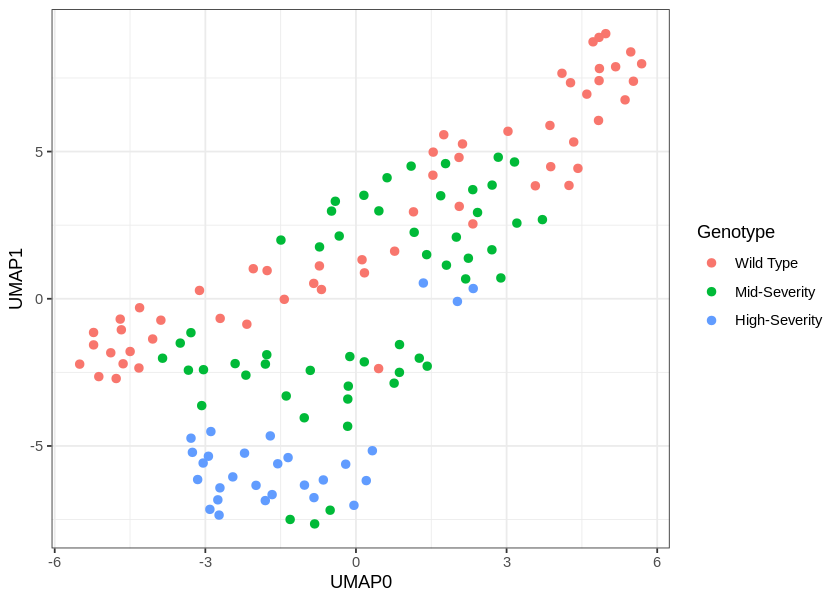

In [5]:
# umap
width <- 7
height <- 5
options(repr.plot.width = width, repr.plot.height = height)
umap_df <- umap::umap((features_df), n_neighbors = 7, min_dist = 0.7, n_components = 2, metric = "cosine")
umap_df <- as.data.frame(umap_df$layout)
colnames(umap_df) <- c("UMAP0", "UMAP1")
umap_df <- cbind(metadata_df, umap_df)

# plot umap
umap_plot <- (
    ggplot(umap_df, aes(x = UMAP0, y = UMAP1, color = Metadata_genotype))
    + geom_point(size = 2)

    + theme_bw()
    + guides(color = guide_legend(title = "Genotype"))
)
umap_plot
# save the plot
ggsave("non_aggregated_umap_plot_genotype.png", path = file.path(fig_path), width = width, height = height, units = "in", dpi = 600)



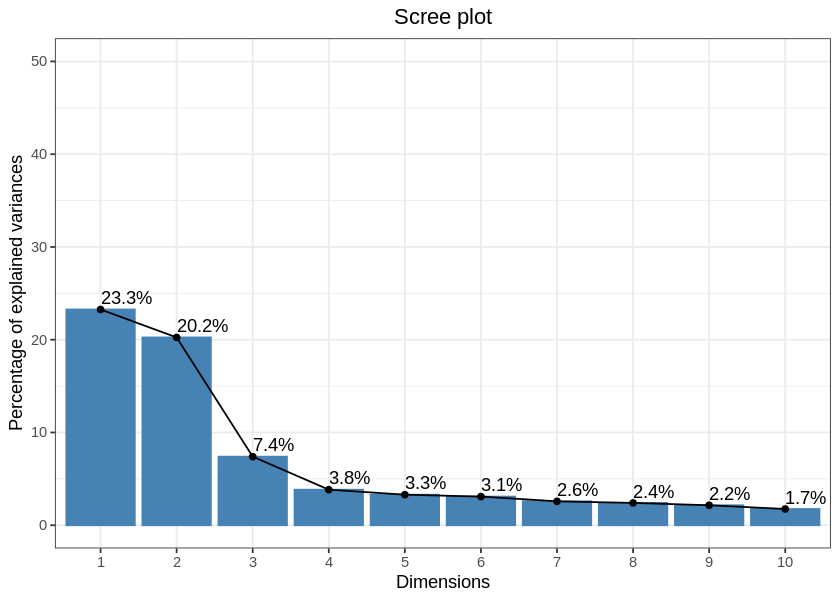

In [6]:

# Apply PCA
res.pca <- prcomp(features_df, scale = TRUE)

# Create scree plot
scree_plot <- fviz_eig(res.pca, addlabels = TRUE, ylim = c(0, 50))
scree_plot <- (
    scree_plot
    + theme_bw()
    # title centered
    + theme(plot.title = element_text(hjust = 0.5))
)
scree_plot
# save the plot
ggsave("non_aggregated_scree_plot.png", path = file.path(fig_path), width = width, height = height, units = "in", dpi = 600)

### PCA with genotype

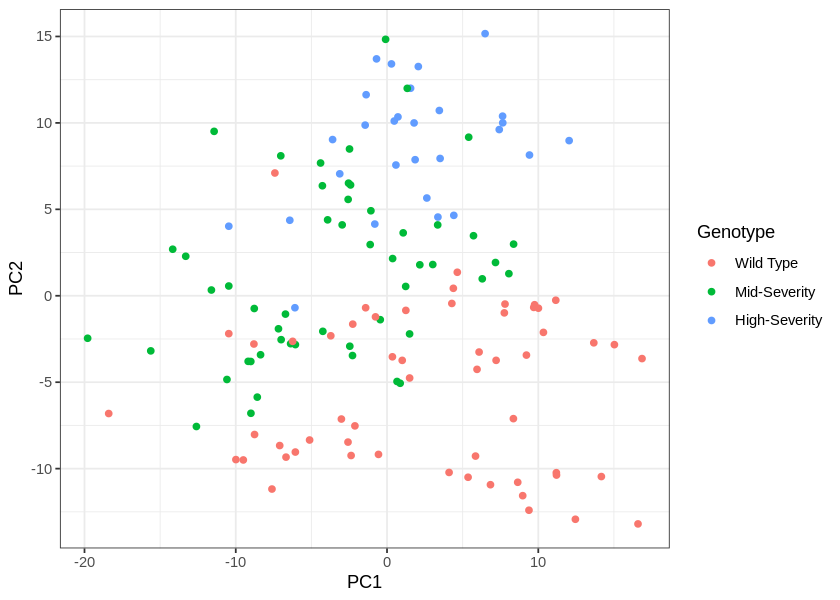

In [7]:
# pca analysis
pca_df <- as.data.frame(res.pca$x)
pca_df <- cbind(metadata_df, pca_df)

# plot pca
pca_plot <- (
    ggplot(pca_df, aes(x = PC1, y = PC2, color = Metadata_genotype))
    + geom_point()
    + theme_bw()
    + guides(color = guide_legend(title = "Genotype"))
)
pca_plot
# save the plot
ggsave("non_aggregated_pca_plot_genotype.png", path = file.path(fig_path), width = width, height = height, units = "in", dpi = 600)


In [8]:
# save the pca results as a parquet file
arrow::write_parquet(pca_df, pca_file_path)